# Data analysis: air pollutant concentration
Feature Engineering for Time Series Forecasting

In this notebook, we will analyse time series data on pollutant concentration.

## Dataset
We will work with the Air Quality Dataset from the UCI Machine Learning Repository.

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repository.

## Data set synopsis
We will work with the variable relative humidity (RH) and CO concentration (CO_sensor).

Both are time series.

This dataset is particularly challenging because timestamps are not equidistant. Entire days of recordings are missing, probably due to data collection failure. There are also outliers wherever the sensors did not manage to obtain a measurement of humidity or CO concentration.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load data

In [2]:
# If you followed the instructions, the data should be
# located here:

filename = "../datasets/AirQualityUCI_ready.csv"

# The variables we will use in this demo:
variables = ["Date_Time", "CO_sensor", "RH"]

# Load data:
data = pd.read_csv(filename, usecols=variables, index_col=["Date_Time"])

data.head()

,CO_sensor,RH
Date_Time,,
2004-10-03 18:00:00,1360.0,48.9
2004-10-03 19:00:00,1292.0,47.7
2004-10-03 20:00:00,1402.0,54.0
2004-10-03 21:00:00,1376.0,60.0
2004-10-03 22:00:00,1272.0,59.6


* timestamp in the index.

* CO_sensor: carbon monoxide concentration.

* RH: relative humidity (in the air).

In [3]:
# cast datetime variable in datetime format
data.index = pd.to_datetime(data.index)

data.index

DatetimeIndex(['2004-10-03 18:00:00', '2004-10-03 19:00:00',
               '2004-10-03 20:00:00', '2004-10-03 21:00:00',
               '2004-10-03 22:00:00', '2004-10-03 23:00:00',
               '2004-11-03 00:00:00', '2004-11-03 01:00:00',
               '2004-11-03 02:00:00', '2004-11-03 03:00:00',
               ...
               '2005-04-04 05:00:00', '2005-04-04 06:00:00',
               '2005-04-04 07:00:00', '2005-04-04 08:00:00',
               '2005-04-04 09:00:00', '2005-04-04 10:00:00',
               '2005-04-04 11:00:00', '2005-04-04 12:00:00',
               '2005-04-04 13:00:00', '2005-04-04 14:00:00'],
              dtype='datetime64[ns]', name='Date_Time', length=9357, freq=None)

In [4]:
# reduce data span (poor data quality outside these dates)
data = data.loc['2004-04-04':'2005-04-04']

In [5]:
# Sanity check: data span.

data.index.min(), data.index.max()

(Timestamp('2004-04-04 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [6]:
# quick check: missing data
# at first sight, no data missing

data.isnull().sum()

CO_sensor    0
RH           0
dtype: int64

## Quick analysis - plot time series

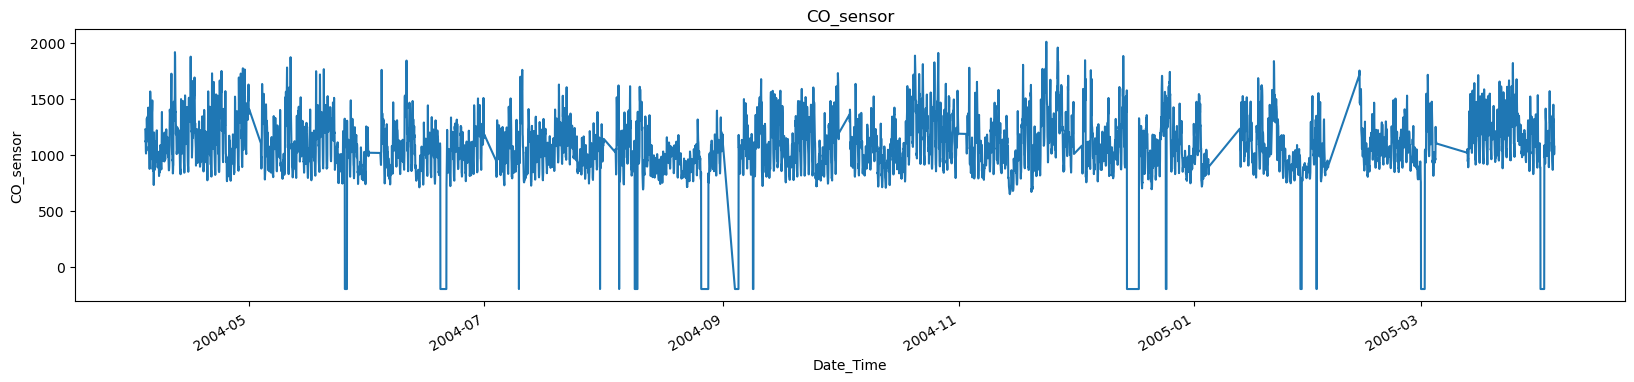

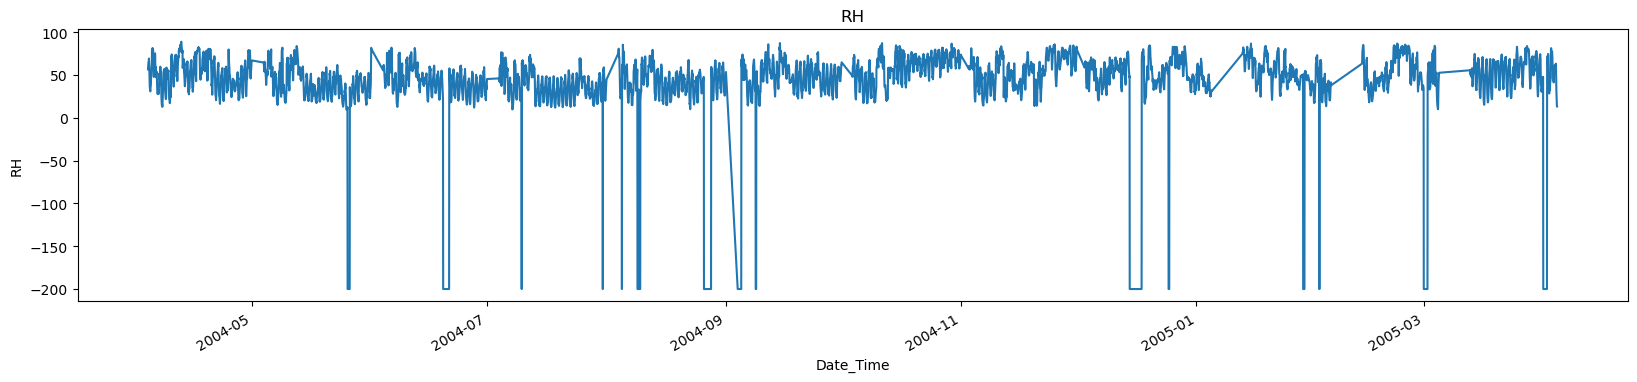

In [7]:
# plot the time series

for var in ['CO_sensor', 'RH']:
    # plot 
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    plt.ylabel(var)
    plt.show()


Looking at the plots, we see the following:

There are records missing: pandas plot interpolates linearly between available values.

Some values are negative, most likely measurement errors, as concentration or humidity level can't be negative.

In [8]:
# remove outliers
data = data.loc[(data['CO_sensor'] >= 0) & (data['RH'] >= 0)]

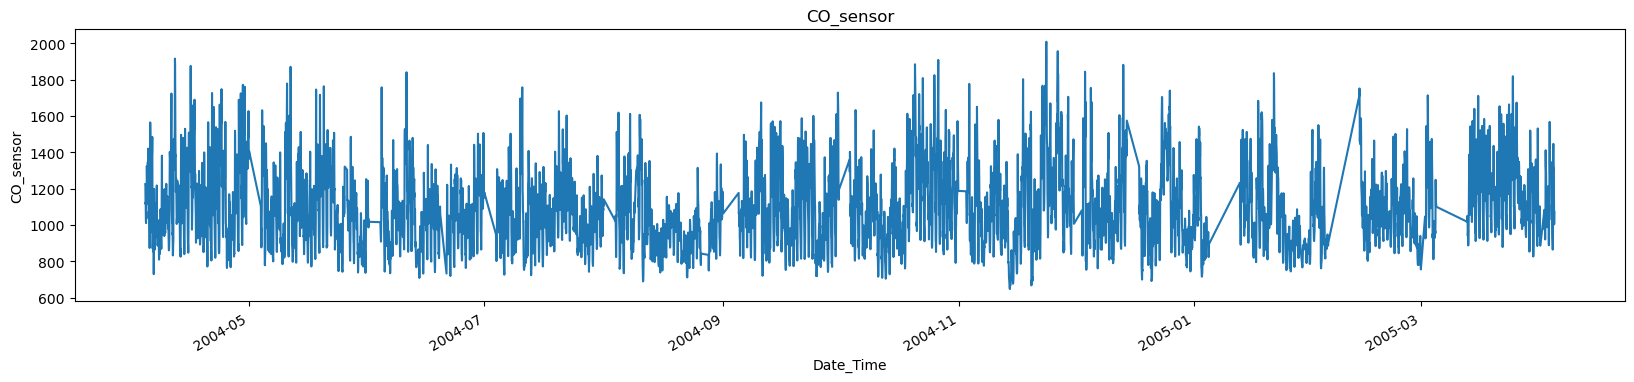

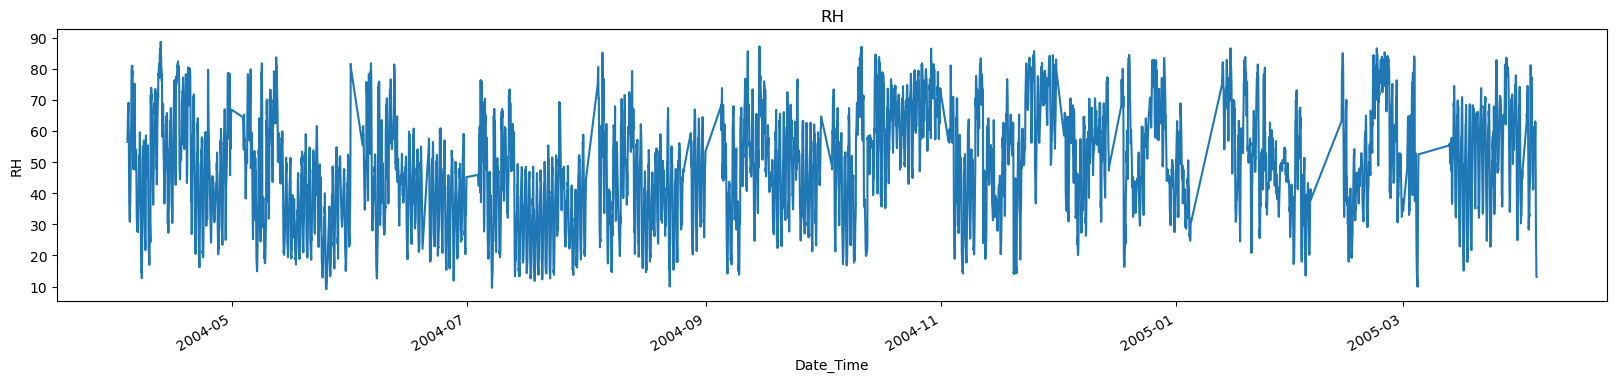

In [9]:
# plot the time series again
# plot the time series

for var in ['CO_sensor', 'RH']:
    # plot 
    data[var].plot(figsize=(20, 4))
    plt.title(var)
    plt.ylabel(var)
    plt.show()

## Highlight missing timestamps
To highlight the missing timestamps, I will first introduce the missing timestamps in the dataset. This will introduce NaN into the variables.

Then I will fill in the NAN, carrying the last value forward. And finally, I will plot the imputed data to highlight the missing timestamps.

In [12]:
# introduce the missing timestamps
# note that we capture this in a different dataframe

data_ = data.asfreq('1H')    # 1 hour bin

# apply the forward fill method
data_imputed = data_.fillna(method='ffill')

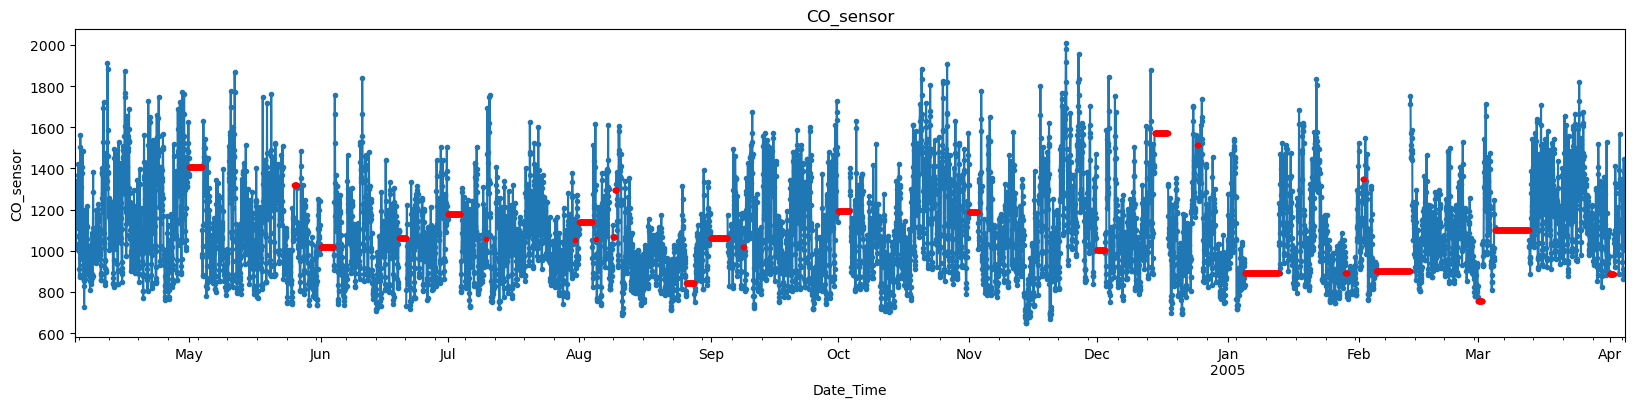

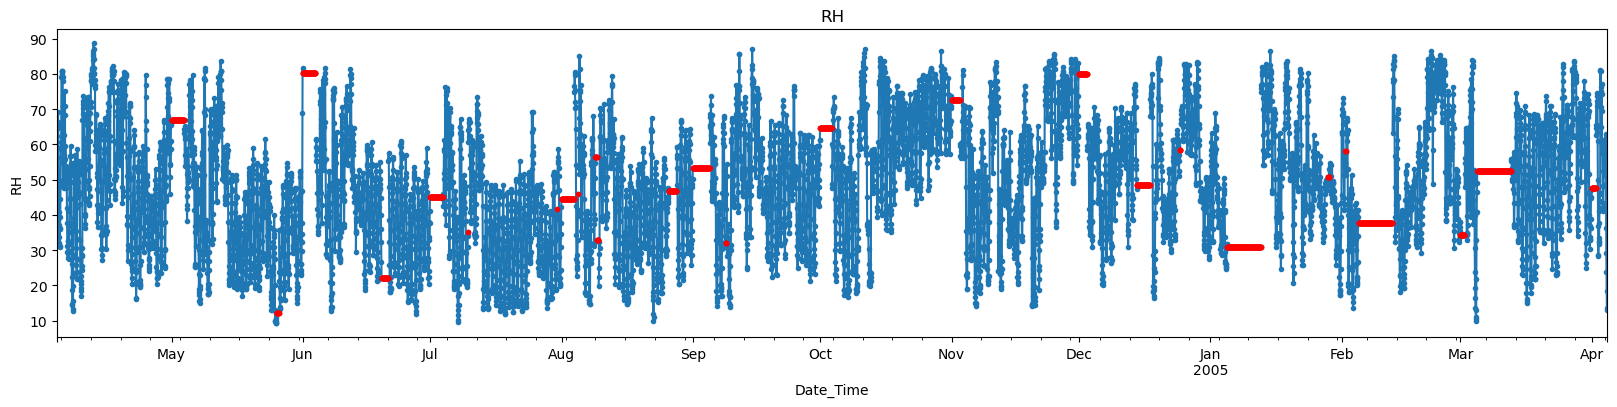

In [13]:
# plot the imputed time series
for var in ['CO_sensor', 'RH']:
    # plot the time series
    ax = data_[var].plot(linestyle='-', marker='.', figsize=[20, 4])
    # plot the imputed values on top, in red
    data_imputed[data_.isnull()][var].plot(ax=ax, legend=None, marker='.', color='r')
    # add title
    plt.title(var)
    plt.ylabel(var)
    plt.show()

## Seasonality
Air pollutant concentration changes with car traffic. At rush hour, we have more pollutants. During the night hours, we have fewer pollutants.

Let's see if what I am saying is true.

In [14]:
# capture 'time' in a new variable
time_ = data.index.time
time_ = pd.Series(time_, index=data.index)
time_.head()

Date_Time
2004-10-03 18:00:00    18:00:00
2004-10-03 19:00:00    19:00:00
2004-10-03 20:00:00    20:00:00
2004-10-03 21:00:00    21:00:00
2004-10-03 22:00:00    22:00:00
dtype: object

Text(0, 0.5, 'Concentration')

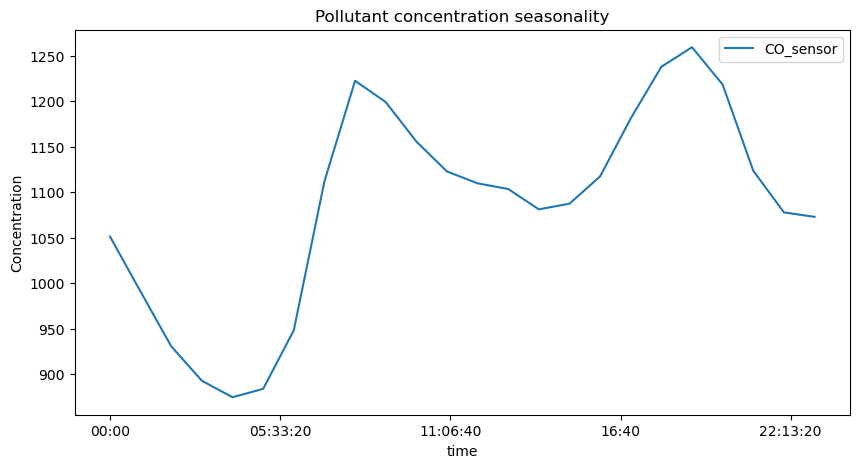

In [15]:
# plot the average pollutant concentration per hour
data.groupby(time_)[['CO_sensor']].mean().plot(figsize=(10, 5))
plt.title('Pollutant concentration seasonality')
plt.ylabel('Concentration')

Text(0, 0.5, 'Concentration')

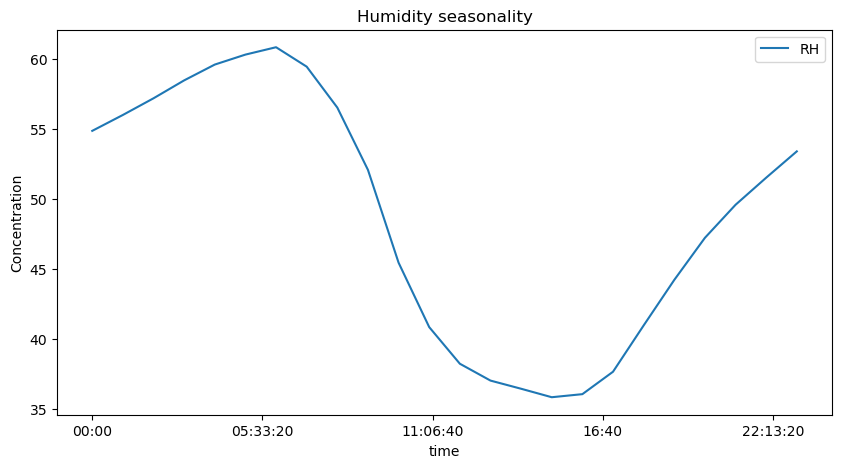

In [16]:
# plot the average humidity per hour
data.groupby(time_)[['RH']].mean().plot(figsize=(10, 5))
plt.title('Humidity seasonality')
plt.ylabel('Concentration')


Bingo! More pollutants are detected around 8–9 a.m. and again at 18–19 hs.